In [1]:
import warnings

import cv2
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from glob import iglob
from scipy.spatial.distance import cityblock, cosine

from comparative_feret_algorithms.fast import dimensionality_reduction as dr
from comparative_feret_algorithms.fast import k_nearest_neighbours as knn

In [2]:
warnings.filterwarnings('ignore')
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
def center(X):
    return X - np.mean(X, axis=0)

In [4]:
def standardize(X):
    return X / np.std(X, axis=0)

In [19]:
# Read image files
def read_images(directory_name):
    X = []; y = []
    for image in iglob("data/" + directory_name + "/*.pgm"):
        face = cv2.resize(plt.imread(image), (50, 60)).flatten()
        X = np.append(X, face)
        y = np.append(y, image.split("/")[2][:5])
    X = np.reshape(X, (-1, 3000))
    return X, y

In [6]:
X, y = read_images("training_set/cropped")
Xt = np.transpose(X)
X = center(X); X = standardize(X)
Xt = center(Xt); Xt = standardize(Xt)

In [8]:
pca = dr.PCA(X, 400)
pcat = dr.PCA(Xt, 400)
ica1 = dr.ICA(np.dot(Xt, pcat.components), 400)
ica2 = dr.ICA(np.dot(X, pca.components), 400)
lda = dr.LDA(np.dot(X, pca.components), y, 400)

In [9]:
pca.explained_variance

98.94831085205078

In [10]:
PC = pca.components
IC1 = np.dot(ica1.components, np.transpose(PC))
IC2 = np.dot(ica2.components, np.transpose(PC))
LD = np.dot(lda.components, np.transpose(PC))

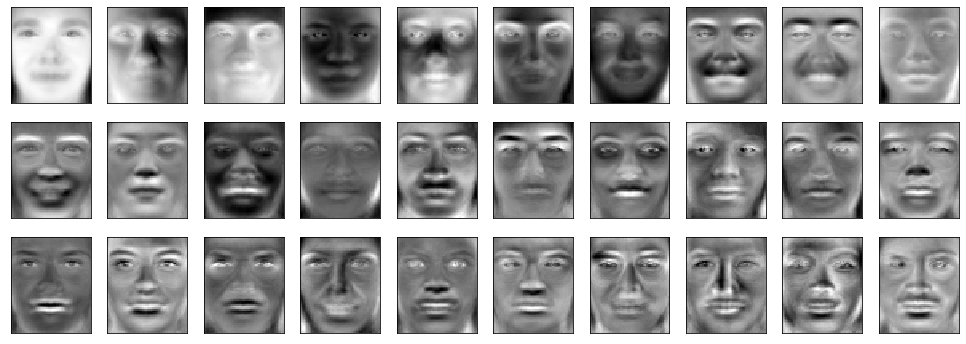

In [11]:
PC_ = np.transpose(PC)
fig, axes = plt.subplots(3, 10, figsize=(17, 6), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(PC_[i].reshape(60, 50), cmap="gray")

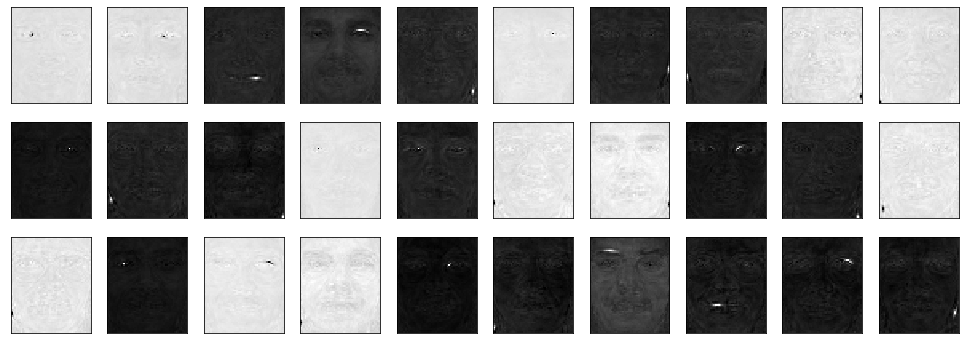

In [12]:
IC1_ = np.dot(ica1.components, np.dot(np.transpose(pcat.components), X))
fig, axes = plt.subplots(3, 10, figsize=(17, 6), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC1_[i].reshape(60, 50), cmap="gray")

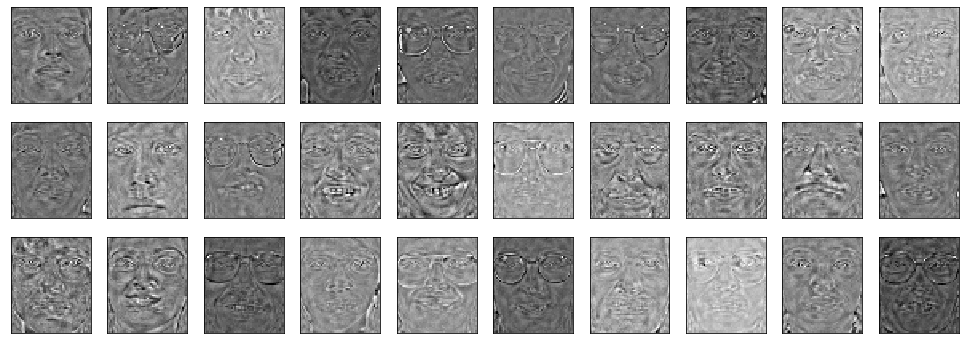

In [13]:
fig, axes = plt.subplots(3, 10, figsize=(17, 6), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(IC2[i].reshape(60, 50), cmap="gray")

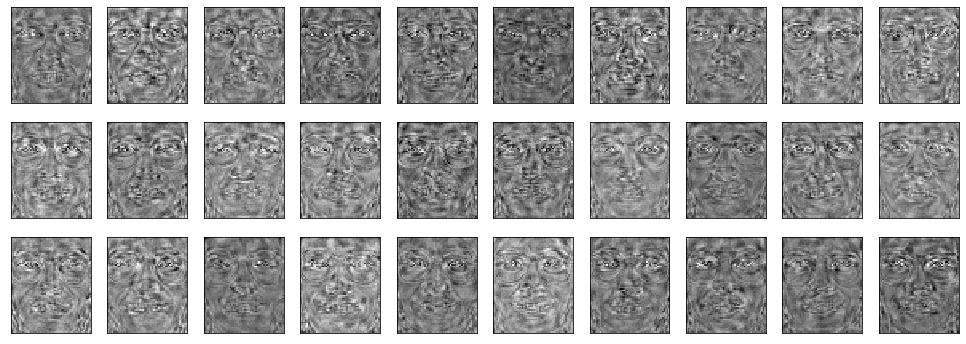

In [14]:
fig, axes = plt.subplots(3, 10, figsize=(17, 6), subplot_kw={"xticks":[], "yticks":[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(LD[i].reshape(60, 50), cmap="gray")

In [20]:
Xg, yg = read_images("gallery")
Xg = center(Xg); Xg = standardize(Xg)
Xg_pca = np.dot(Xg, PC)
Xg_ica1 = np.dot(Xg, np.transpose(IC1))
Xg_ica2 = np.dot(Xg, np.transpose(IC2))
Xg_lda = np.dot(Xg, np.transpose(LD))

In [23]:
Xfb, yfb = read_images("fb")
Xfb = center(Xfb); Xfb = standardize(Xfb)
Xfb_pca = np.dot(Xfb, PC)
Xfb_ica1 = np.dot(Xfb, np.transpose(IC1))
Xfb_ica2 = np.dot(Xfb, np.transpose(IC2))
Xfb_lda = np.dot(Xfb, np.transpose(LD))

In [24]:
Xfc, yfc = read_images("fc")
Xfc = center(Xfc); Xfc = standardize(Xfc)
Xfc_pca = np.dot(Xfc, PC)
Xfc_ica1 = np.dot(Xfc, np.transpose(IC1))
Xfc_ica2 = np.dot(Xfc, np.transpose(IC2))
Xfc_lda = np.dot(Xfc, np.transpose(LD))

In [25]:
Xd1, yd1 = read_images("dup1")
Xd1 = center(Xd1); Xd1 = standardize(Xd1)
Xd1_pca = np.dot(Xd1, PC)
Xd1_ica1 = np.dot(Xd1, np.transpose(IC1))
Xd1_ica2 = np.dot(Xd1, np.transpose(IC2))
Xd1_lda = np.dot(Xd1, np.transpose(LD))

In [26]:
Xd2, yd2 = read_images("dup2")
Xd2 = center(Xd2); Xd2 = standardize(Xd2)
Xd2_pca = np.dot(Xd2, PC)
Xd2_ica1 = np.dot(Xd2, np.transpose(IC1))
Xd2_ica2 = np.dot(Xd2, np.transpose(IC2))
Xd2_lda = np.dot(Xd2, np.transpose(LD))

In [27]:
# Faster than SciPy's Manhattan
def euclidean(a, b):
    return np.linalg.norm(a - b)

In [28]:
def performance(rank, knn_, X, y):
    true = 0; total = len(X)
    for i in range(total):
        if y[i] in knn_.find_knn(rank, X[i]):
            true += 1
    return round(true / total*100, 2)

In [29]:
# PCA kNN
pca_l1 = knn.kNN(Xg_pca, yg, cityblock, 100)
pca_l2 = knn.kNN(Xg_pca, yg, euclidean, 100)
pca_cos = knn.kNN(Xg_pca, yg, cosine, 100)

In [30]:
# ICA1 kNN
ica1_l1 = knn.kNN(Xg_ica1, yg, cityblock, 100)
ica1_l2 = knn.kNN(Xg_ica1, yg, euclidean, 100)
ica1_cos = knn.kNN(Xg_ica1, yg, cosine, 100)

In [31]:
# ICA2 kNN
ica2_l1 = knn.kNN(Xg_ica2, yg, cityblock, 100)
ica2_l2 = knn.kNN(Xg_ica2, yg, euclidean, 100)
ica2_cos = knn.kNN(Xg_ica2, yg, cosine, 100)

In [32]:
# LDA kNN
lda_l1 = knn.kNN(Xg_lda, yg, cityblock, 100)
lda_l2 = knn.kNN(Xg_lda, yg, euclidean, 100)
lda_cos = knn.kNN(Xg_lda, yg, cosine, 100)

# Fb probe set

In [33]:
print("PCA+L1: " + str(performance(1, pca_l1, Xfb_pca, yfb)))
print("PCA+L2: " + str(performance(1, pca_l2, Xfb_pca, yfb)))
print("PCA+COS: " + str(performance(1, pca_cos, Xfb_pca, yfb)))

PCA+L1: 72.72
PCA+L2: 66.19
PCA+COS: 69.29


In [34]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xfb_ica1, yfb)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xfb_ica1, yfb)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xfb_ica1, yfb)))

ICA1+L1: 47.87
ICA1+L2: 47.78
ICA1+COS: 77.15


In [35]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xfb_ica2, yfb)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xfb_ica2, yfb)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xfb_ica2, yfb)))

ICA2+L1: 42.43
ICA2+L2: 46.44
ICA2+COS: 76.82


In [36]:
print("LCA+L1: " + str(performance(1, lda_l1, Xfb_lda, yfb)))
print("LCA+L2: " + str(performance(1, lda_l2, Xfb_lda, yfb)))
print("LCA+COS: " + str(performance(1, lda_cos, Xfb_lda, yfb)))

LCA+L1: 78.16
LCA+L2: 66.19
LCA+COS: 69.29


# Fc probe set

In [37]:
print("PCA+L1: " + str(performance(1, pca_l1, Xfc_pca, yfc)))
print("PCA+L2: " + str(performance(1, pca_l2, Xfc_pca, yfc)))
print("PCA+COS: " + str(performance(1, pca_cos, Xfc_pca, yfc)))

PCA+L1: 66.49
PCA+L2: 30.93
PCA+COS: 38.66


In [38]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xfc_ica1, yfc)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xfc_ica1, yfc)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xfc_ica1, yfc)))

ICA1+L1: 45.88
ICA1+L2: 46.91
ICA1+COS: 72.68


In [39]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xfc_ica2, yfc)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xfc_ica2, yfc)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xfc_ica2, yfc)))

ICA2+L1: 39.69
ICA2+L2: 46.39
ICA2+COS: 70.62


In [40]:
print("LDA+L1: " + str(performance(1, lda_l1, Xfc_lda, yfc)))
print("LDA+L2: " + str(performance(1, lda_l2, Xfc_lda, yfc)))
print("LDA+COS: " + str(performance(1, lda_cos, Xfc_lda, yfc)))

LDA+L1: 71.65
LDA+L2: 30.93
LDA+COS: 38.66


# DUP1 probe set

In [41]:
print("PCA+L1: " + str(performance(1, pca_l1, Xd1_pca, yd1)))
print("PCA+L2: " + str(performance(1, pca_l2, Xd1_pca, yd1)))
print("PCA+COS: " + str(performance(1, pca_cos, Xd1_pca, yd1)))

PCA+L1: 30.89
PCA+L2: 20.64
PCA+COS: 23.82


In [42]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xd1_ica1, yd1)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xd1_ica1, yd1)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xd1_ica1, yd1)))

ICA1+L1: 15.65
ICA1+L2: 15.51
ICA1+COS: 38.09


In [43]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xd1_ica2, yd1)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xd1_ica2, yd1)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xd1_ica2, yd1)))

ICA2+L1: 11.36
ICA2+L2: 14.4
ICA2+COS: 38.64


In [44]:
print("LDA+L1: " + str(performance(1, lda_l1, Xd1_lda, yd1)))
print("LDA+L2: " + str(performance(1, lda_l2, Xd1_lda, yd1)))
print("LDA+COS: " + str(performance(1, lda_cos, Xd1_lda, yd1)))

LDA+L1: 38.64
LDA+L2: 20.64
LDA+COS: 24.1


# DUP2 probe set

In [45]:
print("PCA+L1: " + str(performance(1, pca_l1, Xd2_pca, yd2)))
print("PCA+L2: " + str(performance(1, pca_l2, Xd2_pca, yd2)))
print("PCA+COS: " + str(performance(1, pca_cos, Xd2_pca, yd2)))

PCA+L1: 19.23
PCA+L2: 10.68
PCA+COS: 14.53


In [46]:
print("ICA1+L1: " + str(performance(1, ica1_l1, Xd2_ica1, yd2)))
print("ICA1+L2: " + str(performance(1, ica1_l2, Xd2_ica1, yd2)))
print("ICA1+COS: " + str(performance(1, ica1_cos, Xd2_ica1, yd2)))

ICA1+L1: 9.4
ICA1+L2: 8.97
ICA1+COS: 33.76


In [47]:
print("ICA2+L1: " + str(performance(1, ica2_l1, Xd2_ica2, yd2)))
print("ICA2+L2: " + str(performance(1, ica2_l2, Xd2_ica2, yd2)))
print("ICA2+COS: " + str(performance(1, ica2_cos, Xd2_ica2, yd2)))

ICA2+L1: 6.41
ICA2+L2: 8.55
ICA2+COS: 33.76


In [48]:
print("LDA+L1: " + str(performance(1, lda_l1, Xd2_lda, yd2)))
print("LDA+L2: " + str(performance(1, lda_l2, Xd2_lda, yd2)))
print("LDA+COS: " + str(performance(1, lda_cos, Xd2_lda, yd2)))

LDA+L1: 23.08
LDA+L2: 10.68
LDA+COS: 14.53


In [ ]:
def kNN(k, metric, xp, Xg, yg):
    order = []
    for i in range(len(Xg)):
        if metric == "L1":
            order.append((cityblock(xp, Xg[i]), i))
        if metric == "L2":
            order.append((np.linalg.norm(xp - Xg[i]), i))
        if metric == "MAH":
            X = np.vstack([xp, Xg[i]])
            V = np.cov(X.T)
            VI = np.linalg.inv(V)
            order.append((mahalanobis(xp, Xg[i], VI), i))
        if metric == "COS":
            order.append((cosine(xp, Xg[i]), i))
    order = sorted(order)
    return [yg[i[1]] for i in order[:k]]

def perf(rank, metric, Xp, yp, Xg, yg):
    true = 0
    total = len(Xp)
    for i in range(total):
        if yp[i] in kNN(rank, metric, Xp[i], Xg, yg):
            true += 1
    return round(true / total * 100, 2)

In [30]:
from sklearn.neighbors import NearestNeighbors

In [31]:
# Fit PCA Nearest Neighbor classifiers
l1_pca = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_pca)
l2_pca = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_pca)
mah_pca = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_pca.T)}).fit(Xg_pca)
cos_pca = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_pca)
# Fit ICA1 Nearest Neighbor classifiers
l1_ica1 = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_ica1)
l2_ica1 = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_ica1)
mah_ica1 = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_ica1.T)}).fit(Xg_ica1)
cos_ica1 = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_ica1)
# Fit ICA2 Nearest Neighbor classifiers
l1_ica2 = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_ica2)
l2_ica2 = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_ica2)
mah_ica2 = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_ica2.T)}).fit(Xg_ica2)
cos_ica2 = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_ica2)
# Fit LDA Nearest Neighbor classifiers
l1_lda = NearestNeighbors(n_neighbors=1, metric="l1").fit(Xg_lda)
l2_lda = NearestNeighbors(n_neighbors=1, metric="l2").fit(Xg_lda)
mah_lda = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(Xg_lda.T)}).fit(Xg_lda)
cos_lda = NearestNeighbors(n_neighbors=1, metric="cosine").fit(Xg_lda)

In [40]:
# Calculate the performance of an algorithms wrt a measure
def performance(nn, X_pr, y_pr, X_gal, y_gal, rank):
    true = 0
    total = X_pr.shape[0]
    for i in range(total):
        if y_pr[i] in [y_gal[i] for i in nn.kneighbors(X=[X_pr[i]], n_neighbors=rank)[1][0]]:
            true += 1
    return round(true / total * 100, 2)

# Create a CSM plot
def CSM(nn, probe, gallery):
    csm = []
    for rank in range(0, 81, 5):
        if rank == 0:
            csm.append(performance(nn, probe, gallery, rank+1))
        else:
            csm.append(performance(nn, probe, gallery, rank))
    return csm

In [34]:
print("PCA+L1: " + str(performance(l1_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, Xfb_pca, yfb, Xg_pca, yg, 1)) + "%")

PCA+L1: 74.23%
PCA+L2: 66.03%
PCA+COS: 68.95%


In [35]:
print("ICA1+L1: " + str(performance(l1_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")
print("ICA1+L2: " + str(performance(l2_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")
print("ICA1+COS: " + str(performance(cos_ica1, Xfb_ica1, yfb, Xg_ica1, yg, 1)) + "%")

ICA1+L1: 61.0%
ICA1+L2: 60.59%
ICA1+COS: 76.9%


In [41]:
print("ICA2+L1: " + str(performance(l1_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, Xfb_ica2, yfb, Xg_ica2, yg, 1)) + "%")

ICA2+L1: 58.41%
ICA2+L2: 59.83%
ICA2+COS: 76.82%


In [42]:
print("LDA+L1: " + str(performance(l1_lda, Xfb_lda, yfb, Xg_lda, yg, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, Xfb_lda, yfb, Xg_lda, yg, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, Xfb_lda, yfb, Xg_lda, yg, 1)) + "%")

LDA+L1: 83.26%
LDA+L2: 80.92%
LDA+COS: 85.61%


In [43]:
print("PCA+L1: " + str(performance(l1_pca, Xfc_pca, yfc, Xg_pca, yg, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, Xfc_pca, yfc, Xg_pca, yg, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, Xfc_pca, yfc, Xg_pca, yg, 1)) + "%")

PCA+L1: 59.28%
PCA+L2: 28.87%
PCA+COS: 37.63%


In [44]:
print("ICA1+L1: " + str(performance(l1_ica1, Xfc_ica1, yfc, Xg_ica1, yg, 1)) + "%")
print("ICA1+L2: " + str(performance(l2_ica1, Xfc_ica1, yfc, Xg_ica1, yg, 1)) + "%")
print("ICA1+COS: " + str(performance(cos_ica1, Xfc_ica1, yfc, Xg_ica1, yg, 1)) + "%")

ICA1+L1: 42.78%
ICA1+L2: 44.85%
ICA1+COS: 63.4%


In [45]:
print("ICA2+L1: " + str(performance(l1_ica2, Xfc_ica2, yfc, Xg_ica2, yg, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, Xfc_ica2, yfc, Xg_ica2, yg, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, Xfc_ica2, yfc, Xg_ica2, yg, 1)) + "%")

ICA2+L1: 30.41%
ICA2+L2: 43.81%
ICA2+COS: 62.89%


In [46]:
print("LDA+L1: " + str(performance(l1_lda, Xfc_lda, yfc, Xg_lda, yg, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, Xfc_lda, yfc, Xg_lda, yg, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, Xfc_lda, yfc, Xg_lda, yg, 1)) + "%")

LDA+L1: 95.88%
LDA+L2: 89.69%
LDA+COS: 89.69%


In [47]:
print("PCA+L1: " + str(performance(l1_pca, Xd1_pca, yd1, Xg_pca, yg, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, Xd1_pca, yd1, Xg_pca, yg, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, Xd1_pca, yd1, Xg_pca, yg, 1)) + "%")

PCA+L1: 32.27%
PCA+L2: 19.53%
PCA+COS: 23.96%


In [48]:
print("ICA1+L1: " + str(performance(l1_ica1, Xd1_ica1, yd1, Xg_ica1, yg, 1)) + "%")
print("ICA1+L2: " + str(performance(l2_ica1, Xd1_ica1, yd1, Xg_ica1, yg, 1)) + "%")
print("ICA1+COS: " + str(performance(cos_ica1, Xd1_ica1, yd1, Xg_ica1, yg, 1)) + "%")

ICA1+L1: 28.25%
ICA1+L2: 29.64%
ICA1+COS: 39.75%


In [49]:
print("ICA2+L1: " + str(performance(l1_ica2, Xd1_ica2, yd1, Xg_ica2, yg, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, Xd1_ica2, yd1, Xg_ica2, yg, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, Xd1_ica2, yd1, Xg_ica2, yg, 1)) + "%")

ICA2+L1: 28.81%
ICA2+L2: 28.95%
ICA2+COS: 39.89%


In [50]:
print("LDA+L1: " + str(performance(l1_lda, Xd1_lda, yd1, Xg_lda, yg, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, Xd1_lda, yd1, Xg_lda, yg, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, Xd1_lda, yd1, Xg_lda, yg, 1)) + "%")

LDA+L1: 41.0%
LDA+L2: 37.67%
LDA+COS: 41.83%


In [51]:
print("PCA+L1: " + str(performance(l1_pca, Xd2_pca, yd2, Xg_pca, yg, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, Xd2_pca, yd2, Xg_pca, yg, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, Xd2_pca, yd2, Xg_pca, yg, 1)) + "%")

PCA+L1: 20.51%
PCA+L2: 10.68%
PCA+COS: 14.53%


In [52]:
print("ICA1+L1: " + str(performance(l1_ica1, Xd2_ica1, yd2, Xg_ica1, yg, 1)) + "%")
print("ICA1+L2: " + str(performance(l2_ica1, Xd2_ica1, yd2, Xg_ica1, yg, 1)) + "%")
print("ICA1+COS: " + str(performance(cos_ica1, Xd2_ica1, yd2, Xg_ica1, yg, 1)) + "%")

ICA1+L1: 15.81%
ICA1+L2: 17.95%
ICA1+COS: 35.47%


In [53]:
print("ICA2+L1: " + str(performance(l1_ica2, Xd2_ica2, yd2, Xg_ica2, yg, 1)) + "%")
print("ICA2+L2: " + str(performance(l2_ica2, Xd2_ica2, yd2, Xg_ica2, yg, 1)) + "%")
print("ICA2+COS: " + str(performance(cos_ica2, Xd2_ica2, yd2, Xg_ica2, yg, 1)) + "%")

ICA2+L1: 16.24%
ICA2+L2: 17.52%
ICA2+COS: 35.9%


In [54]:
print("LDA+L1: " + str(performance(l1_lda, Xd2_lda, yd2, Xg_lda, yg, 1)) + "%")
print("LDA+L2: " + str(performance(l2_lda, Xd2_lda, yd2, Xg_lda, yg, 1)) + "%")
print("LDA+COS: " + str(performance(cos_lda, Xd2_lda, yd2, Xg_lda, yg, 1)) + "%")

LDA+L1: 26.07%
LDA+L2: 25.64%
LDA+COS: 34.62%


In [ ]:
CMS_fb = pd.DataFrame()

In [ ]:
CMS_fb["PCA_L1"] = CSM(nn_l1, fb, gallery)
CMS_fb["PCA_L2"] = CSM(nn_l2, fb, gallery)
CMS_fb["PCA_COS"] = CSM(nn_cos, fb, gallery)
CMS_fb["PCA_MAH"] = CSM(nn_mah, fb, gallery)

In [ ]:
CMS_fb = CMS_fb.reset_index().rename(columns={'index':'rank'})
CMS_fb['rank'] *= 5
CMS_fb.at[0, 'rank'] = 1

In [ ]:
CMS_fb = pd.melt(CMS_fb, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fb).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(55, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [ ]:
nn_l1 = NearestNeighbors(n_neighbors=1, metric="manhattan")
nn_l1.fit(gallery)
print(str(performance(nn_l1, fc, gallery, 1)) + " %")

In [ ]:
nn_l2 = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn_l2.fit(gallery)
print(str(performance(nn_l2, fc, gallery, 1)) + " %")

In [ ]:
nn_mah = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(gallery.T)})
nn_mah.fit(gallery)
print(str(performance(nn_mah, fc, gallery, 1)) + " %")

In [ ]:
nn_cos = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_cos.fit(gallery)
print(str(performance(nn_cos, fc, gallery, 1)) + " %")

In [ ]:
CMS_fc = pd.DataFrame()

In [ ]:
CMS_fc["PCA_L1"] = CSM(nn_l1, fc, gallery)
CMS_fc["PCA_L2"] = CSM(nn_l2, fc, gallery)
CMS_fc["PCA_COS"] = CSM(nn_cos, fc, gallery)
CMS_fc["PCA_MAH"] = CSM(nn_mah, fc, gallery)

In [ ]:
CMS_fc = CMS_fc.reset_index().rename(columns={'index':'rank'})
CMS_fc['rank'] *= 5
CMS_fc.at[0, 'rank'] = 1

In [ ]:
CMS_fc = pd.melt(CMS_fc, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fc).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(45, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [ ]:
CMS_dup1 = pd.DataFrame()

In [ ]:
CMS_dup1["PCA_L1"] = CSM(nn_l1, dup1, gallery)
CMS_dup1["PCA_L2"] = CSM(nn_l2, dup1, gallery)
CMS_dup1["PCA_COS"] = CSM(nn_cos, dup1, gallery)
CMS_dup1["PCA_MAH"] = CSM(nn_mah, dup1, gallery)

In [ ]:
CMS_dup1 = CMS_dup1.reset_index().rename(columns={'index':'rank'})
CMS_dup1['rank'] *= 5
CMS_dup1.at[0, 'rank'] = 1

In [ ]:
CMS_dup1 = pd.melt(CMS_dup1, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_dup1).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(20, 75))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [ ]:
CMS_dup2 = pd.DataFrame()

In [ ]:
CMS_dup2["PCA_L1"] = CSM(nn_l1, dup2, gallery)
CMS_dup2["PCA_L2"] = CSM(nn_l2, dup2, gallery)
CMS_dup2["PCA_COS"] = CSM(nn_cos, dup2, gallery)
CMS_dup2["PCA_MAH"] = CSM(nn_mah, dup2, gallery)

In [ ]:
CMS_dup2 = CMS_dup2.reset_index().rename(columns={'index':'rank'})
CMS_dup2['rank'] *= 5
CMS_dup2.at[0, 'rank'] = 1

In [ ]:
CMS_dup2 = pd.melt(CMS_dup2, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_dup2).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(15, 75))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()